In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

detect_ai_vs_human_generated_images_path = kagglehub.competition_download('detect-ai-vs-human-generated-images')
alessandrasala79_ai_vs_human_generated_dataset_path = kagglehub.dataset_download('alessandrasala79/ai-vs-human-generated-dataset')

print('Data source import complete.')


100%|██████████| 1.89M/1.89M [00:01<00:00, 1.80MB/s]

Extracting files...


Data source import complete.


In [3]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Read train data

In [4]:
import pandas as pd
import os

image_dataset_path = "/kaggle/input/ai-vs-human-generated-dataset/"

train_df = pd.read_csv(image_dataset_path + "train.csv")

train_df["file_name"] = image_dataset_path + train_df["file_name"]


train_df.head()


,Unnamed: 0,file_name,label
0,0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  79950 non-null  int64 
 1   file_name   79950 non-null  object
 2   label       79950 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [6]:
train_df=train_df.drop('Unnamed: 0',axis=1)


# Check if the training files exist

In [7]:
import os

missing_files = train_df[~train_df["file_name"].apply(os.path.exists)]
print(f"Missing train images: {len(missing_files)}")

Missing train images: 0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  79950 non-null  object
 1   label      79950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


# View Ai images and Human images

In [9]:
import random
from PIL import Image

ai_images = train_df[train_df["label"] == 1]["file_name"].tolist()
human_images = train_df[train_df["label"] == 0]["file_name"].tolist()

# Function to display images
def show_images(image_paths, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random.sample(image_paths, num_images)):
        img = Image.open(img_path)  # Open image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()


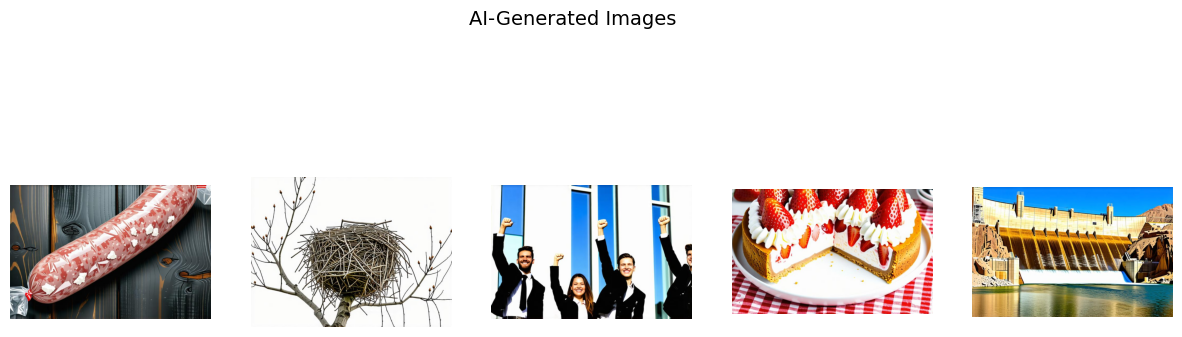

In [10]:
show_images(ai_images, "AI-Generated Images")


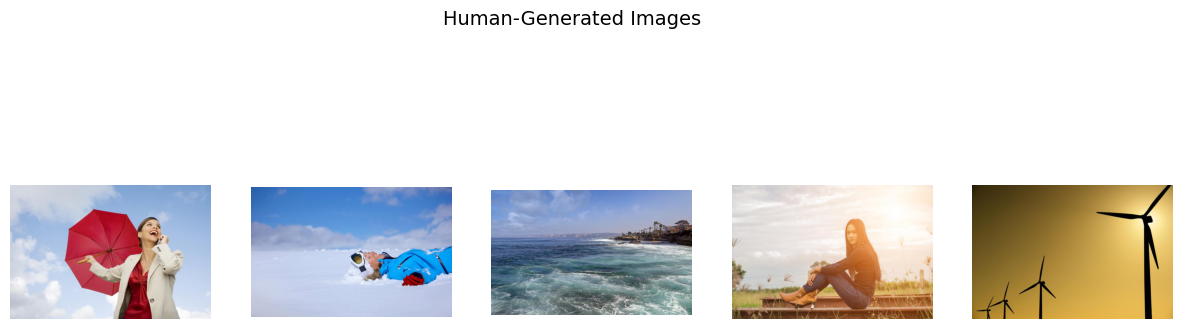

In [11]:
show_images(human_images, "Human-Generated Images")


# Show Similar photos in both

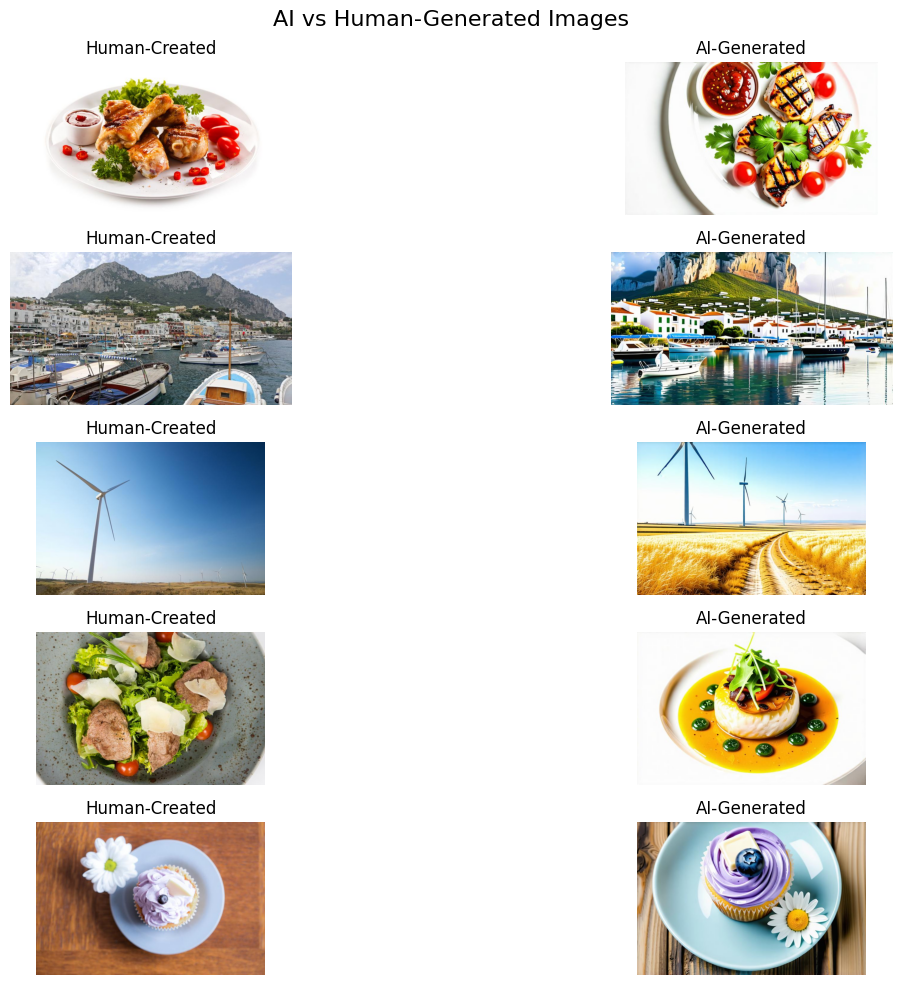

In [12]:
import cv2

def show_ai_vs_human(df, num_images=5):
    ai_images = df[df["label"] == 1]["file_name"].dropna().sample(num_images, random_state=42).values
    human_images = df[df["label"] == 0]["file_name"].dropna().sample(num_images, random_state=42).values

    plt.figure(figsize=(15, num_images * 2))

    for i, (ai_img_path, human_img_path) in enumerate(zip(ai_images, human_images)):
        # Read AI Image
        ai_img = cv2.imread(ai_img_path)
        human_img = cv2.imread(human_img_path)

        if ai_img is None or human_img is None:
            print(f"Skipping missing images: {ai_img_path} or {human_img_path}")
            continue  # Skip missing images

        ai_img = cv2.cvtColor(ai_img, cv2.COLOR_BGR2RGB)
        human_img = cv2.cvtColor(human_img, cv2.COLOR_BGR2RGB)

        # Show Human Image
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(human_img)
        plt.axis("off")
        plt.title("Human-Created")

        # Show AI Image
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(ai_img)
        plt.axis("off")
        plt.title("AI-Generated")

    plt.suptitle("AI vs Human-Generated Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display images
show_ai_vs_human(train_df)


# Read test file

In [13]:
import pandas as pd


image_dataset_path = "/kaggle/input/ai-vs-human-generated-dataset/"


test_df = pd.read_csv(image_dataset_path + "test.csv")


test_df["file_path"] = image_dataset_path + test_df["id"]


test_df.head()


,id,file_path
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...


# check if test files exists

In [14]:
import os

missing_files = test_df[~test_df["file_path"].apply(os.path.exists)]

print(f"Missing test images: {len(missing_files)}")


Missing test images: 0


# Show Test Image Photos

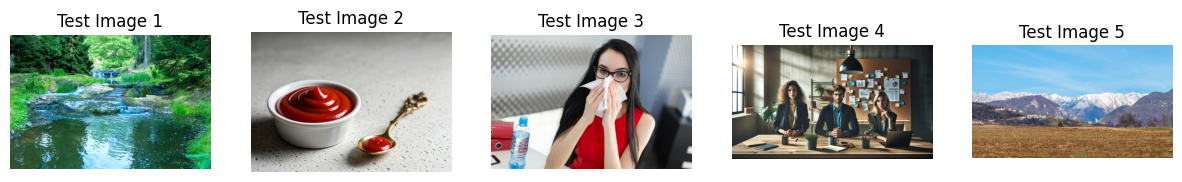

In [15]:
import matplotlib.pyplot as plt
import cv2

def show_test_images(df, num_images=5):
    sample_images = df.sample(num_images, random_state=42)["file_path"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Test Image {i+1}")

    plt.show()

show_test_images(test_df)



In [16]:
print(train_df.head())
print(test_df.head())


                                           file_name  label
0  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
1  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
2  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
3  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
4  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
                                                  id  \
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg   
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg   
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg   
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg   
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg   

                                           file_path  
0  /kaggle/input/ai-vs-human-generated-dataset/te...  
1  /kaggle/input/ai-vs-human-generated-dataset/te...  
2  /kaggle/input/ai-vs-human-generated-dataset/te...  
3  /kaggle/input/ai-vs-human-generated-dataset/te...  
4  /kaggle/input/ai-vs-human

# Convert labels to string

In [17]:
train_df["label"] = train_df["label"].astype(str)

# ImageDataGenerator with rescaling and validation split

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


# train generator

In [19]:
train_generator = data_generator.flow_from_dataframe(
    train_df,
    x_col="file_name",
    y_col="label",
    target_size=(299, 299),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

Found 63960 validated image filenames belonging to 2 classes.


# validation Generator

In [20]:
valid_generator = data_generator.flow_from_dataframe(
    train_df,
    x_col="file_name",
    y_col="label",
    target_size=(299, 299),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 15990 validated image filenames belonging to 2 classes.


# InceptionV3 model

In [21]:

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model.trainable = False



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [22]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature maps to a single vector
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create final model
model = Model(inputs=base_model.input, outputs=output)

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 299, 299,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]  

 Total params: 22,983,457 (87.67 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

# Compile model

In [24]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = 'adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])


# Fitting model

In [25]:
model_history = model.fit(train_generator, epochs=3, validation_data=valid_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 805s 391ms/step - accuracy: 0.7863 - loss: 0.4482 - val_accuracy: 0.8854 - val_loss: 0.2773
Epoch 2/3
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 472s 236ms/step - accuracy: 0.8699 - loss: 0.3015 - val_accuracy: 0.8512 - val_loss: 0.3248
Epoch 3/3
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 422s 211ms/step - accuracy: 0.8818 - loss: 0.2749 - val_accuracy: 0.8910 - val_loss: 0.2598


# train evaluation

In [26]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator)

print(f"Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 343s 172ms/step - accuracy: 0.9023 - loss: 0.2398
Accuracy on train data: 90.29% | Loss: 0.2403


# Test data generator

In [27]:

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_path",
    y_col=None,
    target_size=(299, 299),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 5540 validated image filenames.


# Test Predictions

In [28]:
predictions = model.predict(test_generator)

predicted_labels = (predictions > 0.5).astype(int)

174/174 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step


# submission file

In [30]:
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'label': predicted_labels.flatten()
})

submission_df.to_csv('submission.csv', index=False)

print(submission_df.head(10))

                                                  id  label
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      0
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      0
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      1
5  test_data_v2/d08826f7ccab45c8935d8df5524b2869.jpg      1
6  test_data_v2/8ba52123cc7b4e3aa90e3947734197e0.jpg      0
7  test_data_v2/b107ac0040284f1aace7a6714bf152f7.jpg      0
8  test_data_v2/601c646d626d46da8c5fac6653efcfb8.jpg      1
9  test_data_v2/ef29ead63754441b82b56c1a22082fdf.jpg      0


In [31]:
submission_df['label'].value_counts()

,count
label,
0,3809
1,1731
